In [2]:
# Get the indices of the boundary vertices
function getBoundary(t)
    nt = size(t)[2]
    edge_list = Array{Int64,1}[]
    for i in 1:nt
        push!(edge_list, t[1:2,i])
        push!(edge_list, t[2:3,i])
        push!(edge_list, t[[3,1],i])
    end
    boundary_list = Array{Int64,1}[]
    for i in 1:length(edge_list)
       myedge = edge_list[i][[2,1]]
        if !in(myedge, edge_list)
            push!(boundary_list, edge_list[i])
        end
    end 
    boundary = zeros(Int64, length(boundary_list))
    boundary[1] = boundary_list[1][1]
    for i in 1:length(boundary)
       if i == length(boundary_list) 
           break
       end
        for j in 1:length(boundary_list)
            if boundary_list[j][1] == boundary[i]
             boundary[i+1]  = boundary_list[j][2]
             break
            end
        end
    end
    return boundary
end

# Function to help compute cotangent formula
function getEdge(p, t)
    e1 = p[:, vec(t[3,:])] - p[:, vec(t[2,:])]
    e2 = p[:, vec(t[1,:])] - p[:, vec(t[3,:])]
    e3 = p[:, vec(t[2,:])] - p[:, vec(t[1,:])]
    e1norm = vec(sqrt(sum(e1.^2, 1)))
    e2norm = vec(sqrt(sum(e2.^2, 1)))
    e3norm = vec(sqrt(sum(e3.^2, 1)))
    return e1, e2, e3, e1norm, e2norm, e3norm
end

# Function to compute cotangent formula
function mesh_cot(p, t)
    (e1, e2, e3, e1norm, e2norm, e3norm) = getEdge(p, t)
   e1cos = vec(sum(-e2 .* e3, 1)) ./ e2norm ./ e3norm
   e2cos = vec(sum(-e3 .* e1, 1)) ./ e3norm ./ e1norm
   e3cos = vec(sum(-e1 .* e2, 1)) ./ e1norm ./ e2norm
    r1 = zeros(Float64, size(t)) 
    r2 = zeros(Float64, size(t)) 
    r3 = zeros(Float64, size(t)) 
    for i in 1:size(t)[2]
      r1[:,i] = cross(e2[:,i], e3[:,i])  
      r2[:,i] = cross(e3[:,i], e1[:,i])  
      r3[:,i] = cross(e1[:,i], e2[:,i])  
    end
   e1sin = vec(sqrt(sum(r1.^2,1))) ./ e2norm ./ e3norm
   e2sin = vec(sqrt(sum(r2.^2,1))) ./ e3norm ./ e1norm
   e3sin = vec(sqrt(sum(r3.^2,1))) ./ e1norm ./ e2norm
   e1cot = e1cos ./ e1sin;
   e2cot = e2cos ./ e2sin;
   e3cot = e3cos ./ e3sin;
   return vec(e1cot), vec(e2cot), vec(e3cot)
end

# Function to make Laplacian matrix
function WCot(p, t)
    n = size(p)[2]
    (e1cot, e2cot, e3cot) = mesh_cot(p, t);
    I = [vec(t[2,:]); vec(t[3,:]); vec(t[1,:])]
    J = [vec(t[3,:]); vec(t[1,:]); vec(t[2,:])]
    S = [e1cot; e2cot; e3cot]
    W = sparse(I,J,S, n, n)
    #Wfull = Float64[ W[i,j] for i in 1:n, j in 1:n]
    return W
end

# Function to make Laplacian matrix
function LCot(p, t)
    n = size(p)[2]
    W = WCot(p,t)
    W = W + transpose(W)
    L = sparse(1:n, 1:n, vec(sum(W,2))) - W
    #Lfull = Float64[ L[i,j] for i in 1:n, j in 1:n]
    return L
end

# An ad hoc way to get an initial x0 for the augrumented Lagrangian method
# It is called Tutte embedding.
function Ltut(p, t)
	n = size(p)[2]
    I = [vec(t[2,:]); vec(t[3,:]); vec(t[1,:])]
    J = [vec(t[3,:]); vec(t[1,:]); vec(t[2,:])]
    S = ones(length(I))
    W = sparse(I,J,S, n, n)
    W = W + transpose(W)
    L = sparse(1:n, 1:n, vec(sum(W,2))) - W
    
    boundary = getBoundary(t)
    nb = length(boundary)
    theta = (2pi/nb) * (0:(nb-1))

	b1 = zeros(Float64, n)
	b2 = zeros(Float64, n)

	for k = 1:nb
		b1 = b1 - L[:, boundary[k]] * cos(theta[k])
		b2 = b2 - L[:, boundary[k]] * sin(theta[k])
	end
	b1[boundary] = cos(theta)
	b2[boundary] = sin(theta)

	Lw = copy(L)
	Lw[:, boundary] = 0
	Lw[boundary,:] = 0
	for k = 1:nb
		Lw[boundary[k],boundary[k]] = 1
	end

	uv = Lw \ [b1 b2]
	return uv
end

Ltut (generic function with 1 method)

In [3]:
# A type which stores all the things we need for the optimization problem
immutable ConfOpt
    Q::SparseMatrixCSC{Float64,Int64}
    H::Array{SparseMatrixCSC{Float64,Int64},1}
    A::Array{SparseMatrixCSC{Float64,Int64},1}
    b::Array{Float64,1}
    n::Int64
    m::Int64
    objFun::Function
    objGrad::Function
    objHess::Function
    constrFun::Function
    constrGrad::Function
    constrHess::Array{Function,1}
    augLagFun::Function
    augLagGrad::Function
    augLagHess::Function
    x0::Array{Float64,1}
    p::Array{Float64,2}
    t::Array{Int64,2}
    boundary::Array{Int64,1}
    boundary_3point::Array{Int64,1}
    boundary_3point_v::Array{Float64,2}
end

# Type constructor for the type ConfOpt
function ConfOpt(p::Array{Float64,2}, t::Array{Int64,2})
    n = size(p,2)
    boundary = getBoundary(t)
    nb = length(boundary)

    Qraw = LCot(p,t)
    Q = [Qraw zeros(n,n); zeros(n,n) Qraw]

	H = Array{Float64,2}[]
	for i in 1:nb
		G = zeros(Float64, 2, 2n)
		G[1,boundary[i]] = 1
		G[2,n + boundary[i]] = 1
		Hi = G.' * G
		push!(H, Hi)
	end

    objFun = function(x::Array{Float64,1}) 0.5 * getindex(x.' * Q * x, 1) end
    objGrad = function(x::Array{Float64,1}) Q * x end
    objHess = function(x::Array{Float64,1}) Q end

    theta = (2pi/3) * [0;1;2]
    boundary_3point = boundary[[1, 1 + div(nb,3), 1 + div(nb,3)*2]]
    boundary_3point_v = [cos(theta).'; sin(theta).']

    A = [zeros(Float64, 1, 2n) for i in 1:6]
    b = zeros(Float64, 6)
    for i in 1:3
    	A[i][1, boundary_3point[i]] = 1
    	A[3+i][1, boundary_3point[i] + n ] = 1
    	b[i] = cos(theta[i])
    	b[3+i] = sin(theta[i])
    end

    constrFun = function(x::Array{Float64,1}) 
    	[Float64[ 0.5* ((x.' * H[i] * x) - 1)[] for i in 1:nb];
    	Float64[ ((A[i] * x) - b[i])[] for i in 1:6]]
	end
    constrGrad = function(x::Array{Float64,1})
    	J = zeros(Float64, 2n, nb+6)
    	for i in 1:nb
	    	J[:,i] = H[i] * x
	    end
	    for i in 1:6
	    	J[:, nb + i] = A[i].'
	    end
    	return J
	end
    constrHess = Function[]
    for i in 1:nb
    	fun = function(x::Array{Float64,1}) H[i] end
    	push!(constrHess, fun)
    end
    for i in 1:6
    	fun = function(x::Array{Float64,1}) zeros(Float64,2n,2n) end
    	push!(constrHess, fun)
    end

    augLagFun = function(x::Array{Float64,1}, y::Array{Float64,1}, rho::Float64)
    	objFun(x) - dot(y, constrFun(x)) + 0.5rho * dot(constrFun(x),constrFun(x))
	end
	augLagGrad = function(x::Array{Float64,1}, y::Array{Float64,1}, rho::Float64)
    	objGrad(x) - constrGrad(x) * y + rho * constrGrad(x) * constrFun(x)
	end
	augLagHess = function(x::Array{Float64,1}, y::Array{Float64,1}, rho::Float64)
		Q - sum(H .* y[1:nb]) + rho * sum(H .* constrFun(x)[1:nb]) + rho * constrGrad(x) * transpose(constrGrad(x))
	end

	uv = Ltut(p, t)
	x0 = [uv[:,1];uv[:,2]]

    return ConfOpt(Q, H, A, b, 2n, nb+6,
    			objFun, objGrad, objHess,
    			constrFun, constrGrad, constrHess,
    			augLagFun, augLagGrad, augLagHess,
    			x0, p, t, boundary, boundary_3point, boundary_3point_v)
end

# Compute the augrumented Lagrangian
function augLagObj(prob::ConfOpt, y::Array{Float64,1}, rho::Float64)
	augLagFun = function(x::Array{Float64,1})
    	prob.objFun(x) - dot(y, prob.constrFun(x)) + 0.5rho * dot(prob.constrFun(x), prob.constrFun(x))
	end
	augLagGrad = function(x::Array{Float64,1})
    	prob.objGrad(x) - prob.constrGrad(x) * y + rho * prob.constrGrad(x) * prob.constrFun(x)
	end
	augLagHess = function(x::Array{Float64,1})
		prob.Q - sum(prob.H .* y[1:(prob.m-6)]) + rho * sum(prob.H .* prob.constrFun(x)[1:(prob.m-6)]) + rho * prob.constrGrad(x) * transpose(prob.constrGrad(x))
	end

	obj = function(x::Array{Float64,1}) 
		return augLagFun(x), augLagGrad(x), augLagHess(x)
	end

	return obj
end


# Modified Newton method
# Modify the eigenvalues to be positive
function BkFunInv(H, ε)
    D, V = eig(Symmetric(H))
    Dp = ifelse(D .> ε, D, ε)
    Dpinv = 1./Dp
    return V * Diagonal(Dpinv) * V'
end

# Back tracking method
function backTracking(obj, x, d, g)
    α = 1
    while (obj(x + α*d)[1] > obj(x)[1] + α * 1e-4 * dot(g, d))
       α = α * 0.5
       if α < 1e-6
           break
       end
    end
    return α
end

# Newton Method
function newtmin(obj, x0; maxIts=1000, optTol=1e-6, BkFlag = false, btFlag = true)
    # BkFlag (optional): true for doing Modified Hessian
    # btFlag (optional): true for doing Back Tracking
    f0, g0, H0 = obj(x0)
    its = 0
    Opt = Float64[]
    xkp = copy(x0)
    for i in 1:maxIts
        xk = copy(xkp)
        fk, gk, Hk = obj(xk)
        opt = norm(gk, 2)
        push!(Opt, opt)
        #if opt < optTol*norm(g0)
        if opt < optTol
            break
        end
        if BkFlag == true
            Bkinv = BkFunInv(Hk, 0.01)
            dk = Bkinv * (- gk)
        else
            dk = Hk \ (- gk)
        end
        if btFlag == true
            αk = backTracking(obj, xk, dk, gk)
        else
            αk = 1
        end
        xkp = xk + αk * dk
        its = its + 1
    end
    return xkp, its, Opt
end

function AugLag(prob::ConfOpt; maxItr=20, optTolck = 1e-8, optTolKKT = 1e-8, rho0 = 10.0)
	y0 = zeros(Float64, prob.m)
	
	rhok = rho0
	yk = copy(y0)
	xk = copy(prob.x0)
    #xk = zeros(Float64, prob.n)

    rho_counter = 0
	counter = 0    
    
    @printf "%6s %6s %18s %18s" "Itr" "rho" "Norm Constr" "Norm AugLag Grad\n"
    storage_cnorm = Float64[]
    storage_lnorm = Float64[]
	for itr = 1:maxItr
		
		xkp = newtmin(augLagObj(prob, yk, rhok), xk, maxIts=20, optTol = (1e-4 / 10^itr ) )[1]
        push!(storage_cnorm, norm(prob.constrFun(xkp)))
        push!(storage_lnorm, norm(prob.objGrad(xk) - prob.constrGrad(xk) * yk))
        @printf "%6d %6.0f %18.12f %18.12f\n" itr rhok storage_cnorm[end] storage_lnorm[end] 
            if norm(prob.constrFun(xkp)) < 1e-3 * (1/2)^rho_counter
			rhokp = rhok
			ykp = yk - rhokp * prob.constrFun(xkp)
			rho_counter = rho_counter + 1
		else
			rhokp = 2.0 * rhok
			ykp = copy(yk)
		end

		rhok = rhokp
		yk = copy(ykp)
		xk = copy(xkp)

		counter = itr
		if (norm(prob.constrFun(xkp)) < optTolck) & (norm( prob.objGrad(xk) - prob.constrGrad(xk) * yk) < optTolKKT)
			break
		end
	end

    return xk, yk, rhok, counter, storage_cnorm, storage_lnorm
end


AugLag (generic function with 1 method)

In [12]:
f = readdlm("testr_f.dat", ',', Int64)
v = readdlm("testr_v.dat", ',', Float64)

f = f.';
v = v.';

In [13]:
myprob = ConfOpt(v, f);
result_x = AugLag(myprob, maxItr=50);

   Itr    rho        Norm Constr   Norm AugLag Grad
     1     10     0.171599403150     2.057986721394
     2     20     0.085962057063     1.711229624559
     3     40     0.043030652004     1.731130532907
     4     80     0.021529351662     1.741232888275
     5    160     0.010768429434     1.746354061387
     6    320     0.005385187546     1.748938391211
     7    640     0.002692841530     1.750237491339
     8   1280     0.001346483290     1.750888917741
     9   2560     0.000673257350     1.751215119100
    10   2560     0.000000114337     0.000000000001
    11   2560     0.000000000197     0.000000000001


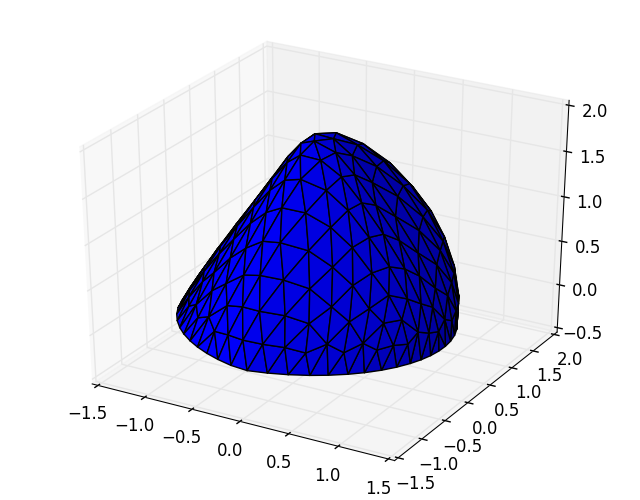

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x31afe8710>

In [14]:
uv = [result_x[1][1:div(myprob.n,2)] result_x[1][div(myprob.n,2) + (1:div(myprob.n,2)) ]]
writecsv("testr_uv.dat", uv)

using PyPlot
function myPlotTri(p, t)
	n = size(p,2)
	if size(p,1) == 2
		plot_trisurf(vec(p[1,:]), vec(p[2,:]), zeros(n), triangles = t.' -1)
	else
		plot_trisurf(vec(p[1,:]), vec(p[2,:]), vec(p[3,:]), triangles = t.' -1)
	end
end

myPlotTri(v, f)

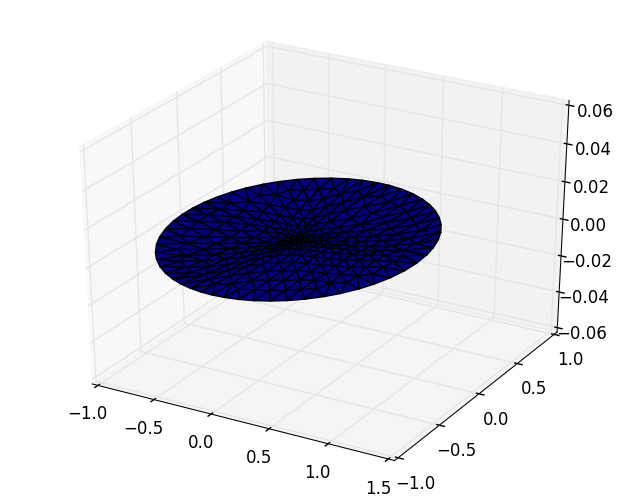

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x31a6c4208>

In [15]:
myPlotTri(uv.', f)

   Itr    rho        Norm Constr   Norm AugLag Grad
     1     10     0.322200556833     4.296581324074
     2     20     0.162975113062     3.112602891839
     3     40     0.082049621748     3.275987170477
     4     80     0.041174790104     3.363717465205
     5    160     0.020626047938     3.409291123305
     6    320     0.010322832301     3.432540894415
     7    640     0.005163886443     3.444286516261
     8   1280     0.002582563077     3.450190167892
     9   2560     0.001291436788     3.453149787933
    10   5120     0.000645757242     3.454631557140
    11   5120     0.000000117213     0.000000000001
    12   5120     0.000000000072     0.000000000001


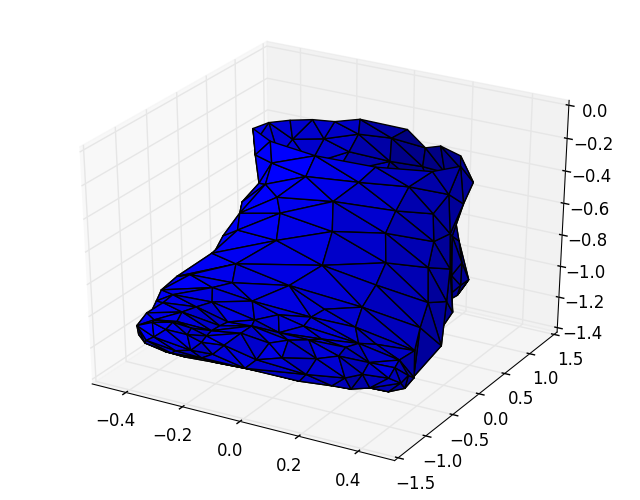

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x31ae20a20>

In [16]:
f = readdlm("foot120_f.dat", ',', Int64)
v = readdlm("foot120_v.dat", ',', Float64)

f = f.';
v = v.';

myprob = ConfOpt(v, f);
result_x = AugLag(myprob, maxItr=50);

uv = [result_x[1][1:div(myprob.n,2)] result_x[1][div(myprob.n,2) + (1:div(myprob.n,2)) ]]
writecsv("foot120_uv.dat", uv)

myPlotTri(v, f)

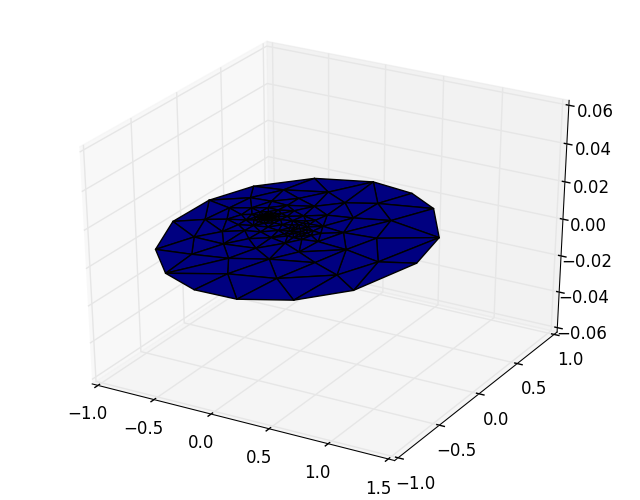

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x31b315518>

In [17]:
myPlotTri(uv.', f)